In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
import powerlaw
from networkx.drawing.nx_agraph import graphviz_layout
import pickle
from statistics import mean, stdev
import seaborn as sns

In [2]:
path = "/Users/damon/Desktop/Dessertion/1-Data Collection/edges.csv"

In [3]:
path_graph = "/Users/damon/Desktop/Dessertion/2-Network Analysis/"

In [4]:
G = nx.read_edgelist(path, comments = "S", delimiter = ",", data=(("Count", int),))

In [5]:
print(nx.info(G))

Graph with 2041 nodes and 6879 edges


/var/folders/7r/_sxj1fdj35s2vf0dwxh35nnc0000gn/T/ipykernel_5727/2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [6]:
er_G = nx.erdos_renyi_graph(G.number_of_nodes(), p=0.001033 , directed = False, seed = 42)
print("Nodes:", er_G.number_of_nodes())
print("Edges:", er_G.number_of_edges())

Nodes: 2041
Edges: 2072


In [7]:
nx.write_graphml(er_G, path_graph+"ER_Network.graphml")

## 1 - Degree Distribution

In [8]:
path_img = "/Users/damon/Desktop/Dessertion/2-Network Analysis"
path_graph = "/Users/damon/Desktop/Dessertion/2-Network Analysis"

def degree_dist(G, name, directory):
    hist = nx.degree_histogram(G)
    plt.plot(range(0, len(hist)), hist, ".")
    plt.title(f"Degree Distribution for {name} graph")
    plt.xlabel("Degree")
    plt.ylabel("P(k)")
    plt.loglog()
    #plt.savefig(path_img+directory+"/degree_dist_"+name+".png")
    plt.show()

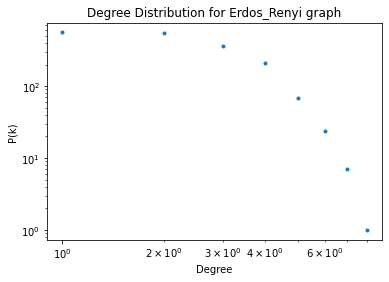

In [9]:
degree_dist(er_G, "Erdos_Renyi", "ER")

In [10]:
def plot_dist(G, name, directory):
    M = nx.to_scipy_sparse_matrix(G)
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0).A[0]
    degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS')#, xmin=xmin, xmax=max(degree)-xmin,discrete=True)
    
    fig = plt.figure(figsize=(16, 6)) 
    print(f"**** Degree Distribution for {name} graph ****")
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)),degree,'b.')   
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')


    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.power_law.plot_pdf(color='r',linestyle='--',label='fit ccdf')
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    #plt.savefig(path_img+directory+"/degree_distribution_compare_"+name+".png")
    plt.show()
    print(f'alpha={fit.power_law.alpha+1} sigma={fit.power_law.sigma}')

/var/folders/7r/_sxj1fdj35s2vf0dwxh35nnc0000gn/T/ipykernel_5727/165580856.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  M = nx.to_scipy_sparse_matrix(G)


Calculating best minimal value for power law fit
**** Degree Distribution for Erdos_Renyi graph ****


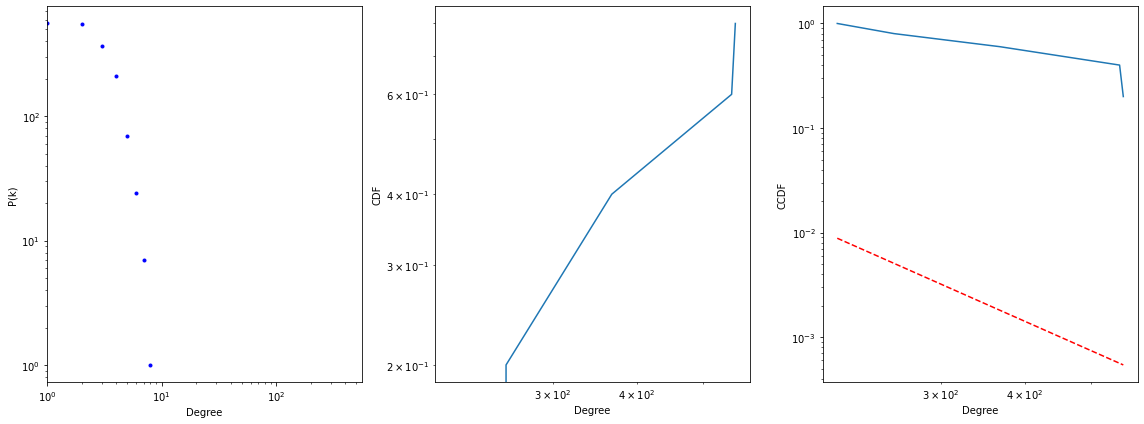

alpha=3.8637214950364465 sigma=0.8334815908058062


In [11]:
plot_dist(er_G, "Erdos_Renyi", "ER")

In [12]:
def info_degree(G, name):
    print(f"***** Degree info for {name} graph ***")
    degree_sequence = sorted([(d, n) for n, d in G.degree()], reverse=True)
    dmax = max(degree_sequence)
    print("Maximum degree:", dmax)
    dmin = min(degree_sequence)
    print("Minimum degree:", dmin)

In [13]:
info_degree(er_G , "Erdos_Renyi")

***** Degree info for Erdos_Renyi graph ***
Maximum degree: (8, 598)
Minimum degree: (0, 12)


## 2 - Connected Components

In [14]:
def n_connected_components(G, name):
    print(f"**** Connected components for {name} graph ****")
    # list of connected components
    n_connected_component = list(nx.connected_components(G))
    print(f"Number of Connected Components for {name}: {len(n_connected_component)}")
    for i in range(len(n_connected_component)):
        if i < 3:
            print(f"\t component len = {len(n_connected_component[i])}")
    # Giant component -> Identify and store giant component
    H = nx.Graph()
    H = nx.subgraph(G,n_connected_component[0])
    nx.write_graphml(G, path_graph+"/giant_component/"+ name+".graphml")
    return n_connected_component

In [15]:
components = n_connected_components(er_G , "Erdos_Renyi")

**** Connected components for Erdos_Renyi graph ****
Number of Connected Components for Erdos_Renyi: 303
	 component len = 1657
	 component len = 1
	 component len = 1


## 3 - Path Analysis

In [16]:
def path_analysis(G, name, components):
    print(f"***** Path analysis for {name} graph")
    print(f"Diameter for components 0 network {name}: {nx.diameter(G.subgraph(components[0]))}")
    print(f"Average shortest path for components 0 network {name}: {nx.average_shortest_path_length(G.subgraph(components[0]))}")

In [17]:
path_analysis(er_G , "Erdos_Renyi", components)

***** Path analysis for Erdos_Renyi graph
Diameter for components 0 network Erdos_Renyi: 23
Average shortest path for components 0 network Erdos_Renyi: 10.160521605019257


## 4 - Clustering Coefficient

In [18]:
def c_coefficient_analysis(G, name):
    #avg_clust_coeff(G, name)
    clustering_g = nx.clustering(G)
    print(f"*** Clustering coefficient analyssi for {name} graph ***")
    #print(f"CC: {clustering_g.values()}")
    print(f"Min: {min(clustering_g.values())}")
    print(f"Max: {max(clustering_g.values())}")
    print(f"Mean: {mean(clustering_g.values())}")
    print(f"Stdev: {stdev(clustering_g.values())}")
    return (name, clustering_g.values())

In [19]:
name, values = c_coefficient_analysis(er_G , "Erdos_Renyi")

*** Clustering coefficient analyssi for Erdos_Renyi graph ***
Min: 0
Max: 0
Mean: 0
Stdev: 0.0


In [20]:
def degree_clustering(G, name, directory):
    print(f"**** Distribution degree/clustering for {name} graph ***")
    degrees = G.degree()
    local_clustering_coefficient= []
    degree = []

    for d in degrees:
        local_clustering_coefficient.append(nx.clustering(G,d[0]))
        #print(local_clustering_coefficient)
        degree.append(d[1])
        
    plt.figure(figsize=(20,5))
    plt.scatter(degree, local_clustering_coefficient)

    plt.xlabel("k")
    plt.ylabel("C(k)")
    #plt.savefig(path_img+directory+"/degree_clustering_"+name+".png")
    plt.show()

**** Distribution degree/clustering for Erdos_Renyi graph ***


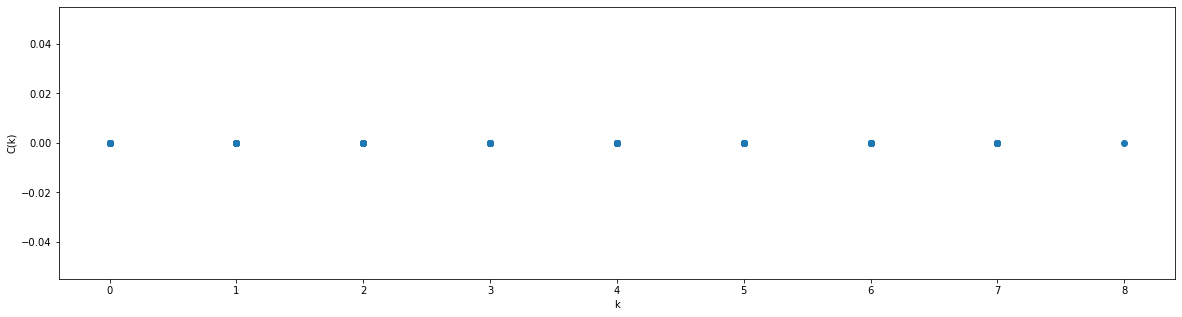

In [21]:
degree_clustering(er_G , "Erdos_Renyi", "ER")

## 5 - Density Analysis

In [22]:
def density_analysis(G, name):
    print(f"Density for {name} graph: {nx.density(G)}")

In [23]:
density_analysis(er_G , "Erdos_Renyi")

Density for Erdos_Renyi graph: 0.0009952829735519883
